In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from itertools import combinations
import cartopy.crs as ccrs

In [2]:
rawdf = pd.read_excel("./Water_Isotopes_Uncorrected.xls")
rawdf.columns = rawdf.columns.str.strip()

infodf = pd.read_csv("./sampleinfo.csv")

In [3]:
nonignore = rawdf[rawdf['Ignore'] == 0]

In [4]:
samples = nonignore.groupby("Identifier 1")

In [5]:
cal_17_16 = {
    'DY-2': -12.22,
    'BOTTY': -3.88,
    'SPIT-2': -0.09
}

cal_18_16 = {
    'DY-2': -23.08,
    'BOTTY': -7.40,
    'SPIT-2': -0.15
}

cal_D_H = {
    'DY-2': -180.47,
    'BOTTY': -50.38,
    'SPIT-2': -0.44
}

isotopes = ['17_16','18_16','D_H']

cal_dicts = {'17_16': cal_17_16, '18_16': cal_18_16, 'D_H': cal_D_H}

labels = {
    "P24-0371": "O20-M-05",
    "P24-0372": "O20-P-02",
    "P24-0373": "O20-M-04",
    "P24-0374": "O20-P-01",
    "P24-0375": "O20-B-12",
    "P24-0376": "O20-B-05",
    "P24-0377": "O20-B-06",
    "P24-0378": "O20-B-02",
    "P24-0379": "O20-R-02",
    "P24-0380": "O20-T-02",
    "P24-0381": "O20-M-01",
    "P24-0382": "O20-M-09",
    "P24-0383": "O20-M-02",
    "P24-0384": "O20-T-04",
    "P24-0385": "O20-T-01",
    "P24-0386": "O20-B-11",
    "P24-0387": "O20-R-01",
    "P24-0388": "O20-M-03",
    "P24-0389": "O20-M-06",
    "P24-0390": "O20-B-08",
    "P24-0391": "O20-B-09",
    "P24-0392": "O20-B-10",
    "P24-0393": "O20-B-04",
    "P24-0394": "O20-T-03",
    "P24-0395": "020-B-13",
    "P24-0396": "O20-B-01",
    "P24-0397": "O20-B-07",
    "P24-0398": "O20-B-03",
    "P24-0399": "O20-M-07",
    "P24-0400": "O20-M-08"
}


In [6]:
##############################
#         PARAMETERS         #
##############################

skipnum = 5       # Number of samples to skip over for each set

Error on DY-2 17_16 -7.534181818181816
Error on BOTTY 17_16 -7.309857142857141
Error on SPIT-2 17_16 -7.1708181818181815
Error on DY-2 18_16 -14.14777272727273
Error on BOTTY 18_16 -13.870122448979588
Error on SPIT-2 18_16 -13.683863636363638
Error on DY-2 D_H 86.54831818181817
Error on BOTTY D_H 104.62151020408163
Error on SPIT-2 D_H 111.82222727272728


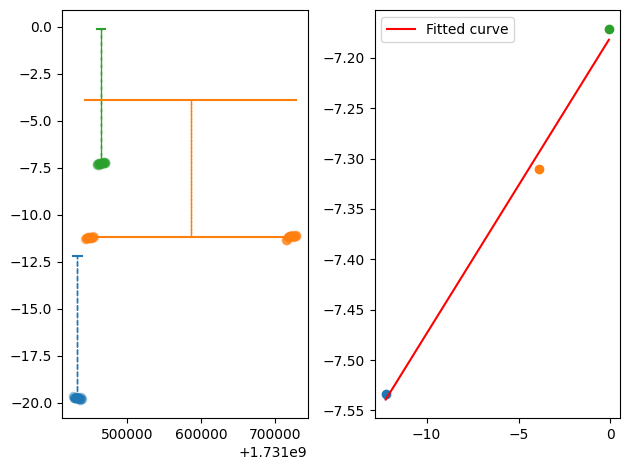

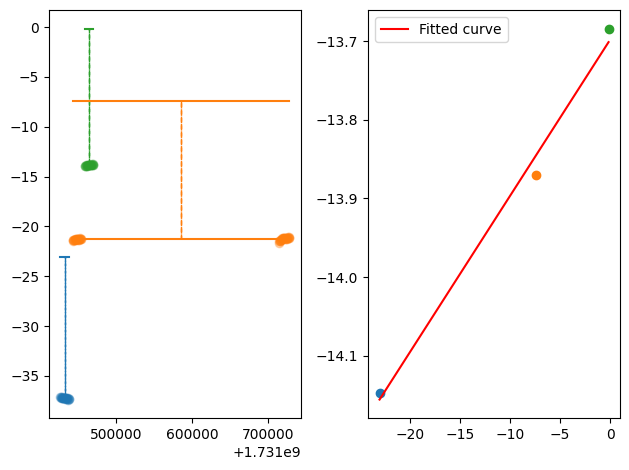

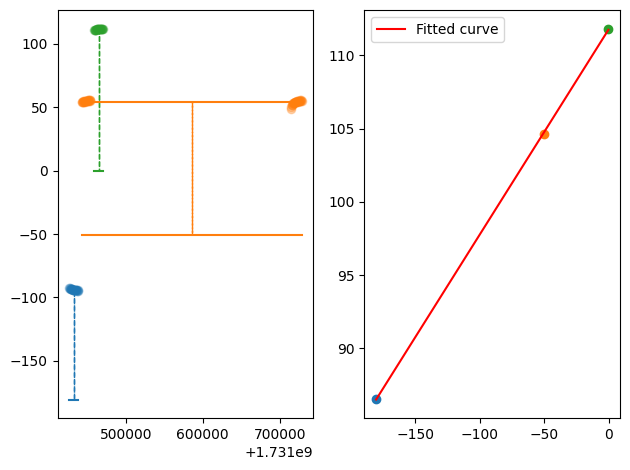

In [13]:
def line_fit(a,b,x):
    return a*x + b

fitsdict = {}

for iso in isotopes:
    cal_data = cal_dicts[iso]
    
    sample_cal = {name.strip(): group for name, 
                  group in samples if name.strip() in cal_data.keys()}

    fig, ax = plt.subplots(ncols=2)

    i=0
    fit_dict = []

    for name, group in sample_cal.items():
        ax[0].scatter(group['Timestamp Mean'][skipnum:], group[f'd({iso})Mean'][skipnum:], alpha=0.3)
        ax[0].plot([group['Timestamp Mean'][skipnum:].min(),group['Timestamp Mean'][skipnum:].max()],
                [cal_data[name],cal_data[name]], c=f'C{i}')
        ax[0].plot([group['Timestamp Mean'][skipnum:].min(),group['Timestamp Mean'][skipnum:].max()],
                [group[f'd({iso})Mean'][skipnum:].mean(),group[f'd({iso})Mean'][skipnum:].mean()], c=f'C{i}')

        ax[0].arrow(x = 0.5 * (group['Timestamp Mean'][skipnum:].min() + group['Timestamp Mean'][skipnum:].max()),
                 y = cal_data[name],
                 dx = 0,
                 dy = - cal_data[name] + group[f'd({iso})Mean'][skipnum:].mean(),
                 color = f'C{i}', ls="--")

        print('Error on',name,iso,- cal_data[name] + group[f'd({iso})Mean'][skipnum:].mean())
        
        i+=1

        ax[1].scatter(cal_data[name], - cal_data[name] + group[f'd({iso})Mean'][skipnum:].mean())

        fit_dict.append([cal_data[name], - cal_data[name] + group[f'd({iso})Mean'][skipnum:].mean()])

    xdata = np.array([i[0] for i in fit_dict])
    ydata = np.array([i[1] for i in fit_dict])

    # Perform curve fitting
    popt, pcov = curve_fit(line_fit, xdata, ydata)

    # Optional: Plot the fitted curve
    x_fit = np.linspace(xdata.min(), xdata.max(), 100)
    y_fit = line_fit(x_fit, *popt)
    ax[1].plot(x_fit, y_fit, color='r', label='Fitted curve')
    ax[1].legend()

    plt.tight_layout()

    fitsdict[iso] = popt

In [8]:
means_dict = {i:{} for i in isotopes}

for sample in samples:
    for iso in isotopes:
        # print((labels[sample[0].strip()] if sample[0].strip() in labels else 'STD'), f'{iso}:', np.mean(sample[1][f'd({iso})Mean'][skipnum:]))
        means_dict[iso][sample[0].strip()] = np.mean(sample[1][f'd({iso})Mean'][skipnum:])

[('D_H', '18_16'), ('D_H', '17_16'), ('18_16', '17_16')]


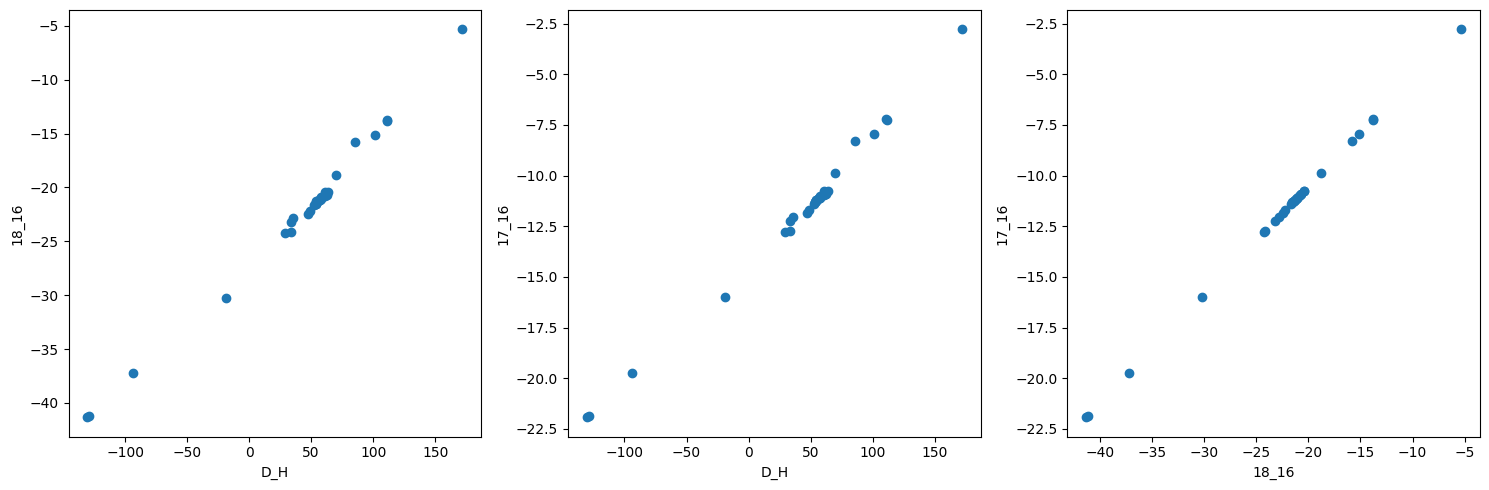

In [100]:
# Pairwise isotope plots (not excess, just linear!)

iso_pairs = list(combinations(isotopes[::-1], 2))

print(iso_pairs)

fig, ax = plt.subplots(ncols=3, figsize=(15,5))

for i, pair in enumerate(iso_pairs):
    ax[i].scatter(means_dict[pair[0]].values(), means_dict[pair[1]].values())

    ax[i].set_ylabel(pair[1])
    ax[i].set_xlabel(pair[0])

plt.tight_layout()

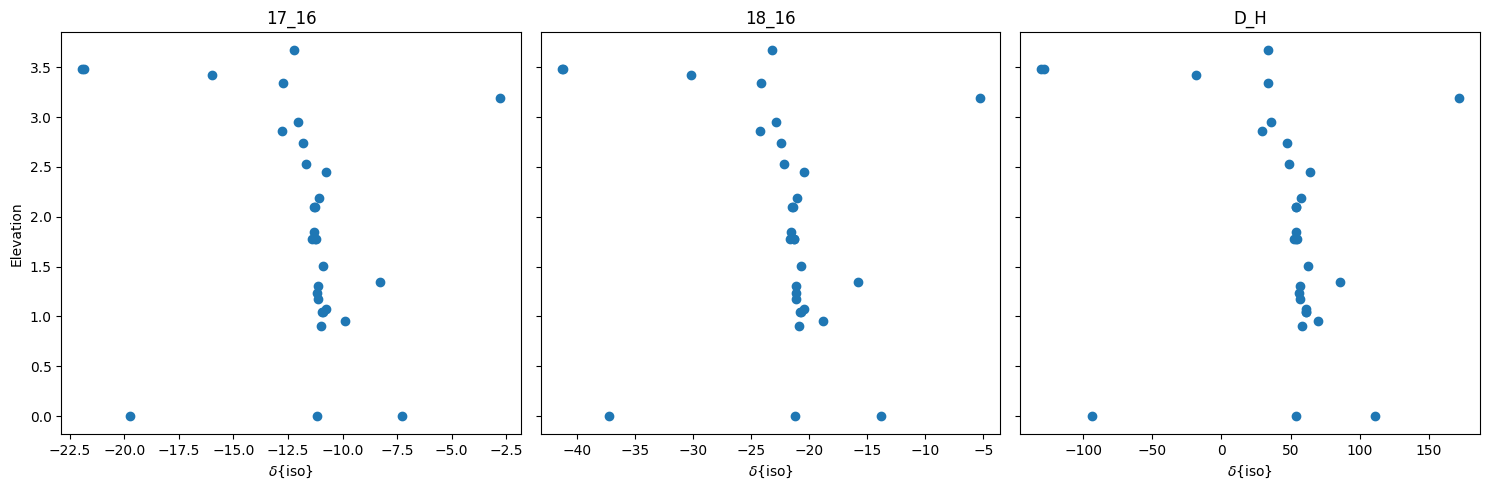

In [29]:
# Plot against elevation

fig, ax = plt.subplots(ncols=3, figsize=(15,5), sharey=True)

for i, iso in enumerate(isotopes):
    for item, value in means_dict[iso].items():
        # print(value, item, infodf[infodf['Sample ID'] == item]['Elevation'])
        ax[i].scatter(value, np.log10((infodf[infodf['Sample ID'] == labels[item]]['Elevation'] if item in labels else 1)), color='C0')

    ax[i].set_title(iso)
    ax[i].set_xlabel(r"$\delta${iso}")
ax[0].set_ylabel('Elevation')
plt.tight_layout()

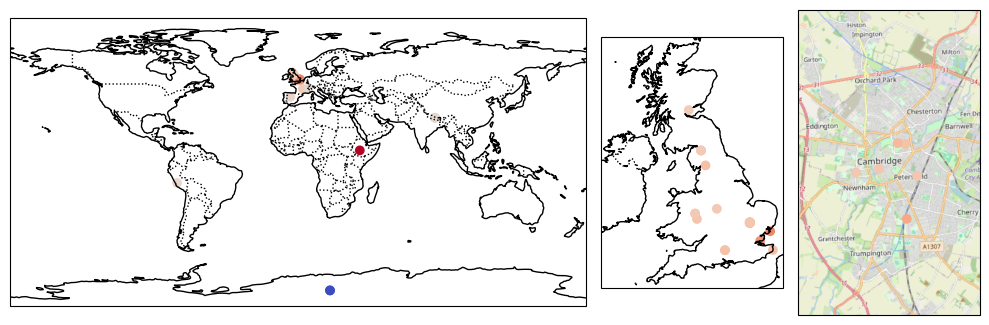

In [99]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

isotope_system = 'D_H'

gbb = {
    "north": 58.735,  # Northernmost point with margin
    "south": 49.859,  # Southernmost point with margin
    "west": -8.249,   # Westernmost point with margin
    "east": 1.868     # Easternmost point with margin
}

camb = {
    "north": 52.256390,  # Northernmost point (approx. 5 km north of the city center)
    "south": 52.152872,  # Southernmost point (approx. 5 km south of the city center)
    "west": 0.076904,  # Westernmost point (approx. 5 km west of the city center)
    "east": 0.174149    # Easternmost point (approx. 5 km east of the city center)
}

fig = plt.figure(figsize=(10, 10))

ax0 = plt.subplot2grid((4, 5), (0, 0), colspan=3, rowspan=2, projection=ccrs.PlateCarree())
ax1 = plt.subplot2grid((4, 5), (0, 3), rowspan=2, projection=ccrs.epsg(27700))
ax2 = plt.subplot2grid((4, 5), (0, 4), rowspan=2, projection=ccrs.epsg(27700))

longitude = [l for l in infodf['Longitude'].values]
latitude = [l for l in infodf['Latitude'].values]
sample_id = [l for l in infodf['Sample ID'].values]

args = {'x':longitude, 'y':latitude, 'c':[means_dict[isotope_system][next((key for key, value in labels.items() if value == k), None)] for k in sample_id], 'cmap':"coolwarm", 'transform':ccrs.PlateCarree()}

ax0.scatter(**args)
ax1.scatter(**args)
ax2.scatter(**args)

# Set map boundaries
ax0.set_xlim(-180, 180)
ax0.set_ylim(-90, 90)

# Add coastlines for geographic context
ax0.coastlines()
ax0.add_feature(cfeature.BORDERS, linestyle=':')

ax1.set_extent([gbb["west"], gbb["east"], gbb["south"], gbb["north"]], crs=ccrs.PlateCarree())

ax1.coastlines(resolution='10m', transform=ccrs.epsg(27700))
ax1.add_feature(cfeature.BORDERS, linestyle=':', transform=ccrs.epsg(27700))

ax2.set_extent([camb["west"], camb["east"], camb["south"], camb["north"]], crs=ccrs.PlateCarree())
osm_tiles = cimgt.OSM()
ax2.add_image(osm_tiles, 12)

plt.tight_layout()
plt.show()

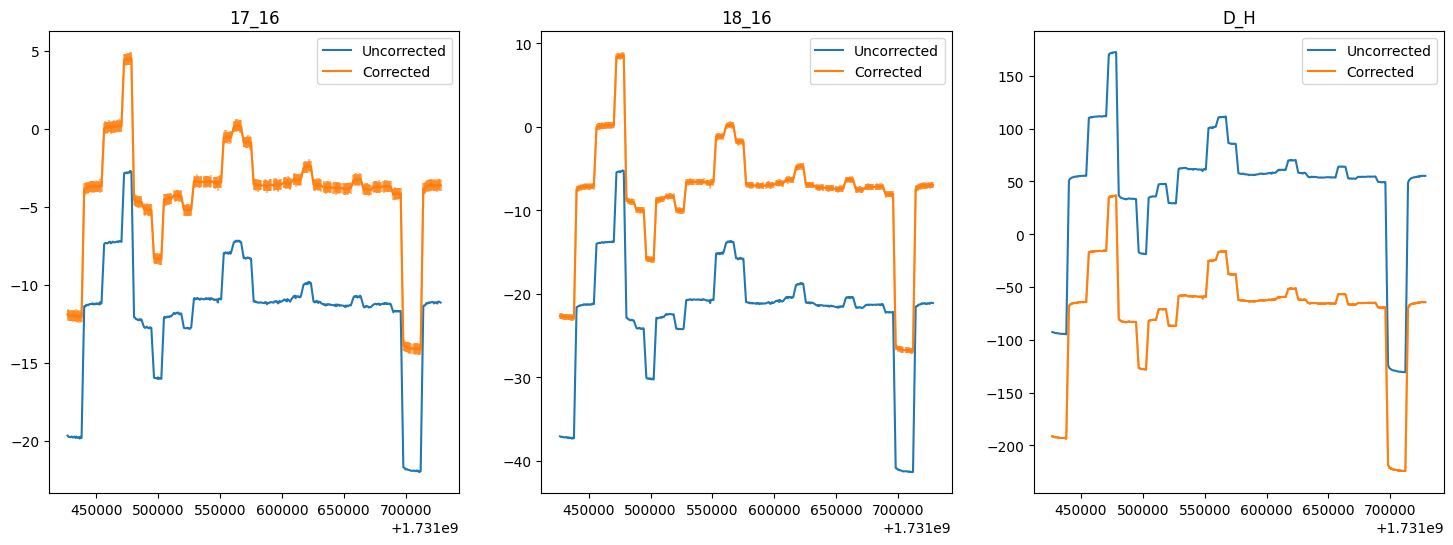

In [10]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6))

for i, iso in enumerate(isotopes):

    to_plot = f'd({iso})Mean'
    error = f'd({iso})_SD'
    
    ax[i].plot(nonignore['Timestamp Mean'][skipnum:], nonignore[to_plot][skipnum:], label="Uncorrected")
    ax[i].plot(nonignore['Timestamp Mean'][skipnum:], nonignore[to_plot][skipnum:] - fitsdict[iso][1]*nonignore[to_plot][skipnum:] - fitsdict[iso][0], label="Corrected")
    
    ax[i].errorbar(nonignore['Timestamp Mean'][skipnum:], nonignore[to_plot][skipnum:] - fitsdict[iso][1]*nonignore[to_plot][skipnum:] - fitsdict[iso][0],yerr=nonignore[error][skipnum:],c='C1',alpha=0.5)

    ax[i].legend()
    ax[i].set_title(f"{iso}")

Text(0.5, 1.0, 'Deuterium Excess')

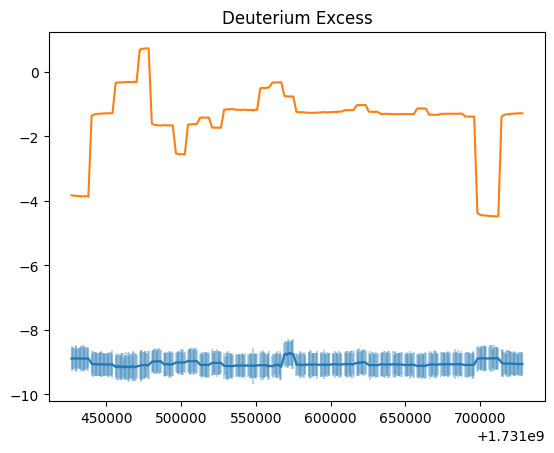

In [101]:
fig, ax = plt.subplots()

ax.plot(nonignore['Timestamp Mean'][skipnum:],(nonignore[to_plot][skipnum:] - fitsdict[iso][1]*nonignore[to_plot][skipnum:] - fitsdict[iso][0]) / 
        (8*(nonignore['d(18_16)Mean'][skipnum:] - fitsdict['18_16'][1]*nonignore[to_plot][skipnum:] - fitsdict['18_16'][0])) - 10, label="Corrected")
ax.plot(nonignore['Timestamp Mean'][skipnum:],(nonignore[to_plot][skipnum:] - fitsdict[iso][1]*nonignore[to_plot][skipnum:] - fitsdict[iso][0]) / 50, label="Corrected")

ax.errorbar(nonignore['Timestamp Mean'][skipnum:],(nonignore[to_plot][skipnum:] - fitsdict[iso][1]*nonignore[to_plot][skipnum:] - fitsdict[iso][0]) / 
        (8*(nonignore['d(18_16)Mean'][skipnum:] - fitsdict['18_16'][1]*nonignore[to_plot][skipnum:] - fitsdict['18_16'][0])) - 10, yerr=nonignore[error][skipnum:] * nonignore['d(18_16)_SD'][skipnum:], alpha=0.3,  c='C0')

# I can't really remember how is appropriate to stack errors like this!

ax.set_title("Deuterium Excess")